## Spin groups and statistics

In [1]:
from ATARI.syndat.sample_widths import sample_RRR_widths
from matplotlib.pyplot import *
import numpy as np
#%%
import numpy as np
import pandas as pd
import os
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.syndat.sample_resparms import sample_resonance_ladder

from ATARI.utils.misc import fine_egrid 
from ATARI.utils.io.experimental_parameters import BuildExperimentalParameters_fromDIRECT
from ATARI.utils.io.theoretical_parameters import BuildTheoreticalParameters_fromHDF5
from ATARI.utils.io.pointwise_container import BuildPointwiseContainer_fromHDF5
from ATARI.utils.io.data_container import BuildDataContainer_fromBUILDERS, BuildDataContainer_fromOBJECTS

In [2]:
%matplotlib widget

### Analyze fits

In [3]:

#%%
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

E_min_max = [75, 125]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}

exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)

from ATARI.theory import scattering_params
shift, penetration, phi, k = scattering_params.FofE_explicit(exp.energy_domain, ac, M, m, 0)

res_par_avg = make_res_par_avg(D_avg = 8.79, 
                               Gn_avg= np.mean(penetration)*2*46.4, 
                               n_dof = 1, 
                               Gg_avg = 64.0, 
                               g_dof = 1000, 
                               print = False)

spin_groups = [ (3.0,1,0) ]
average_parameters = {'3.0':res_par_avg}

# resonance_ladder = sample_resonance_ladder(exp.energy_domain, spin_groups, average_parameters, 
#                                                             use_fudge=False)

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

# build experimental parameters
builder_exppar = BuildExperimentalParameters_fromDIRECT(0.067166, 0, 1e-2)
exppar = builder_exppar.construct()


dcs = {}
for Gg_DOF_true in [1,10,50,100,1000,10000]:
     dcs[Gg_DOF_true] = []

for Gg_DOF_true in [1,10,50,100,1000,10000]:
    case_file = f'/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/varyGg_correctGn/GgDOF_{Gg_DOF_true}.hdf5'

    for isample in range(0,500):

        # build all fits
        parameter_list = []
        for Gg_avg in [60]: #[30, 60, 90]:
            for Gg_dof in [1000]:   #[10, 100, 1000, 10000]:
                    for sig in [0.00001, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]:
                        try:
                            est_par_builder = BuildTheoreticalParameters_fromHDF5(f'par_est_gaF{Gg_avg}_gdF{Gg_dof}_{isample}_pv_{sig:0<10f}', case_file, isample, Ta_pair)
                            est_par = est_par_builder.construct()
                            # dc.add_theoretical_parameters(est_par)
                            parameter_list.append(est_par)
                        except:
                             pass

        # build true model parameter object
        builder_theopar = BuildTheoreticalParameters_fromHDF5('true', case_file, isample, Ta_pair)
        truepar = builder_theopar.construct()
        parameter_list.append(truepar)

        # build pointwise data 
        builder_pw = BuildPointwiseContainer_fromHDF5(case_file, isample)
        # pw = builder_pw.construct_full_noCovT()
        pw = builder_pw.construct_lite()



        # builder_dc = BuildDataContainer_fromOBJECTS( pw, exppar, [truepar])
        builder_dc = BuildDataContainer_fromOBJECTS( pw, exppar, parameter_list)
        dc = builder_dc.construct()

        dcs[Gg_DOF_true].append(dc)
             


In [4]:
# calculate fine pw data
for Gg_DOF_true in [1,10,50,100,1000,10000]:
    for isample in range(0,500):
        dcs[Gg_DOF_true][isample].mem_2_full()

True DOF and Average: 966.0277659520696, 64.02104307278246


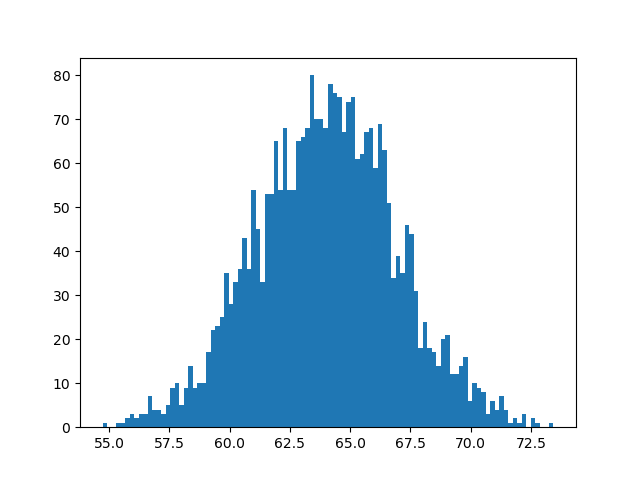

In [5]:
Gg_DOF_true = 1000
case_file = f'/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/varyGg_correctGn/GgDOF_{Gg_DOF_true}.hdf5'

test = []
for i in range(500):
    builder_theopar = BuildTheoreticalParameters_fromHDF5('true', case_file, i, Ta_pair)
    truepar = builder_theopar.construct()
    test.extend(list(truepar.resonance_ladder["Gg"].values))
    # test.append(len(truepar.resonance_ladder))
test = np.array(test)


dof, loc, scale = sts.chi2.fit(test, floc=0)
print(f"True DOF and Average: {dof}, {scale*dof}")

bins = 100
figure()
out = hist(test, density=False, bins = bins, alpha=1, label="True")

In [6]:
residual_dict = {}
relative_residual_dict ={}
Gg_dict = {}
Gn_dict = {}

for Gg_DOF_true in [1,10,50,100,1000,10000]:
    for Gg_avg in [60]: #[30, 60, 90]:
        for Gg_dof in [1000]:   #[10, 100, 1000, 10000]:
                for sig in [0.00001, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]:
                    
                    residual_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'] = []
                    relative_residual_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'] = []
                    Gg_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'] = []
                    Gn_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'] = []
    residual_dict[f'{Gg_DOF_true}_true'] = []
    Gg_dict[f'{Gg_DOF_true}_true'] = []
    Gn_dict[f'{Gg_DOF_true}_true'] = []

for i in range(0,500):
    for Gg_DOF_true in [1,10,50,100,1000,10000]:
        truepar = dcs[Gg_DOF_true][i].theoretical_parameters['true'].resonance_ladder
        true_xsfine = dcs[Gg_DOF_true][i].pw.fine["true_xs"]
        Gg_dict[f'{Gg_DOF_true}_true'].extend(list(truepar["Gg"].values))
        Gn_dict[f'{Gg_DOF_true}_true'].extend(list(truepar["Gn"].values))
    
        for Gg_avg in [60]: #[30, 60, 90]:
            for Gg_dof in [1000]:   #[10, 100, 1000, 10000]:
                    for sig in [0.00001, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]:
                         
                        #  dcs[Gg_DOF_true][i].mem_2_full()
                        try:
                            fitpar = dcs[Gg_DOF_true][i].theoretical_parameters[f'par_est_gaF{Gg_avg}_gdF{Gg_dof}_{i}_pv_{sig:0<10f}'].resonance_ladder
                            residual_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'].append( np.array(dcs[Gg_DOF_true][i].pw.fine[f'par_est_gaF{Gg_avg}_gdF{Gg_dof}_{i}_pv_{sig:0<10f}_xs']-true_xsfine))
                            relative_residual_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'].append( np.array( (dcs[Gg_DOF_true][i].pw.fine[f'par_est_gaF{Gg_avg}_gdF{Gg_dof}_{i}_pv_{sig:0<10f}_xs']-true_xsfine)/true_xsfine))
                            Gg_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'].extend(list(fitpar["Gg"].values))
                            Gn_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'].extend(list(fitpar["Gn"].values))
                        except:
                             pass
        


### print FNorm for each sigma in Gg_DOF_true=1000

In [23]:
Gg_DOF_true = 1000
Gg_avg = 60
Gg_dof =1000 
Fnorms = []
sumAbsE = []
sumRelE = []
for sig in [0.00001, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]:
        residual_matrix = np.array(residual_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'])
        relative_residual_matrix = np.array(relative_residual_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'])
        Fnorms.append(np.linalg.norm(residual_matrix)/residual_matrix.size)
        sumAbsE.append(np.sum(abs(residual_matrix))/residual_matrix.size)
        sumRelE.append(np.sum(abs(relative_residual_matrix))/relative_residual_matrix.size)
                        

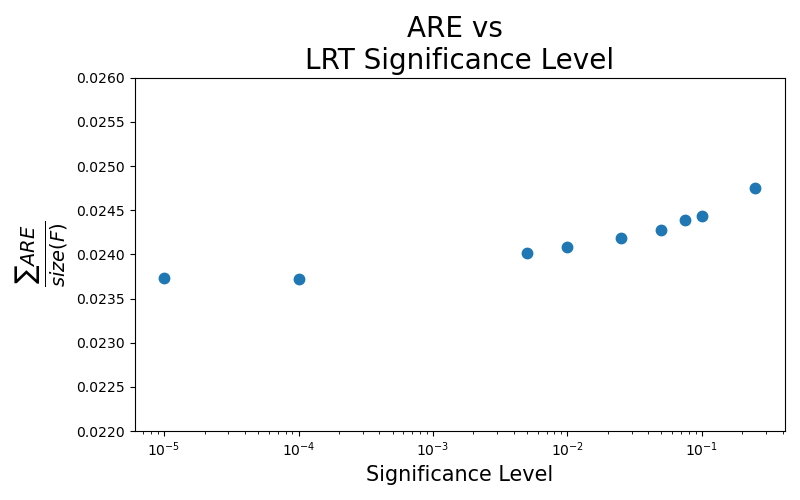

In [41]:
figure(figsize=(8,5))
# plot([0.00001, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25], Fnorms, '.', ms=15)
plot([0.00001, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25], sumRelE, '.', ms=15)
# plot([0.00001, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25], maxE, '.', ms=15)

xscale('log')
# title("Frobeneus Norm Metric vs \nLRT Significance Level", fontsize=20)
title("ARE vs \nLRT Significance Level", fontsize=20)
# ylabel(r"$\frac{|\mathrm{F-T|_F}}{\mathrm{size(F)}}$", fontsize=17)
ylabel(r"$\frac{\sum{ARE}}{size(F)}$", fontsize=20)
# ylim([0.0169, 0.0171999])
ylim([0.022, 0.026])
xlabel("Significance Level", fontsize=15)
xticks(fontsize=10)
yticks(fontsize=10)
tight_layout()

### For a single case, characterize performance

In [9]:
sig = 0.005
residual_matrix = np.array(relative_residual_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'])
relative_residual_matrix = np.array(relative_residual_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'])



In [10]:
np.quantile(abs(residual_matrix), 0.5, axis=1).shape

(498,)

/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_98590/3373554683.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure(figsize=(8,5))


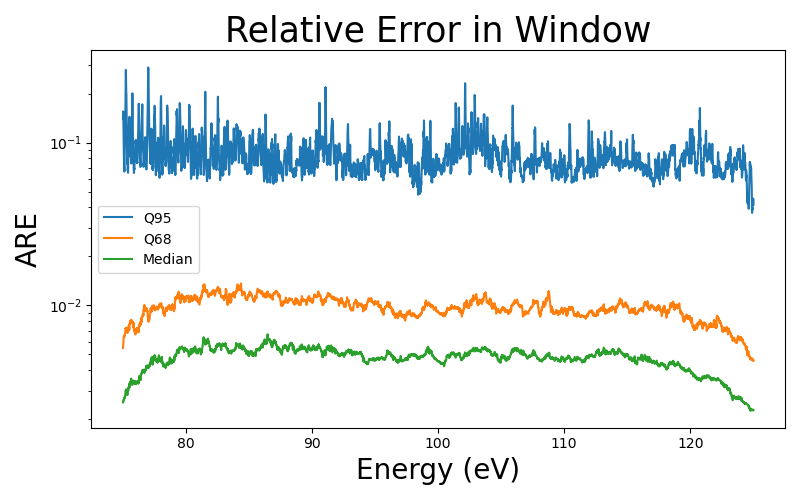

In [30]:
figure(figsize=(8,5))

# plot(dcs[Gg_DOF_true][0].pw.fine.E, np.max(abs(residual_matrix), axis=0), label="Max")
# plot(dcs[Gg_DOF_true][0].pw.fine.E, np.quantile(abs(residual_matrix), 0.95, axis=0), label="Q95")
# # plot(dcs[Gg_DOF_true][0].pw.fine.E, np.mean(abs(residual_matrix),axis=0), label="Mean")
# plot(dcs[Gg_DOF_true][0].pw.fine.E, np.quantile(abs(residual_matrix), 0.68, axis=0), label="Q68")
# plot(dcs[Gg_DOF_true][0].pw.fine.E, np.quantile(abs(residual_matrix), 0.5, axis=0), label="Median")

plot(dcs[Gg_DOF_true][0].pw.fine.E, np.quantile(abs(relative_residual_matrix), 0.95, axis=0), label="Q95")
# plot(dcs[Gg_DOF_true][0].pw.fine.E, np.mean(abs(residual_matrix),axis=0), label="Mean")
plot(dcs[Gg_DOF_true][0].pw.fine.E, np.quantile(abs(relative_residual_matrix), 0.68, axis=0), label="Q68")
plot(dcs[Gg_DOF_true][0].pw.fine.E, np.quantile(abs(relative_residual_matrix), 0.5, axis=0), label="Median")

legend()
yscale('log')
title("Relative Error in Window", fontsize=25)
# ylabel(r"$|\frac{(F-T)}{T}|_\mathrm{abs}$", fontsize=20)
ylabel("ARE", fontsize=20)
xlabel("Energy (eV)", fontsize=20)
xticks(fontsize=10)
yticks(fontsize=10)
tight_layout()

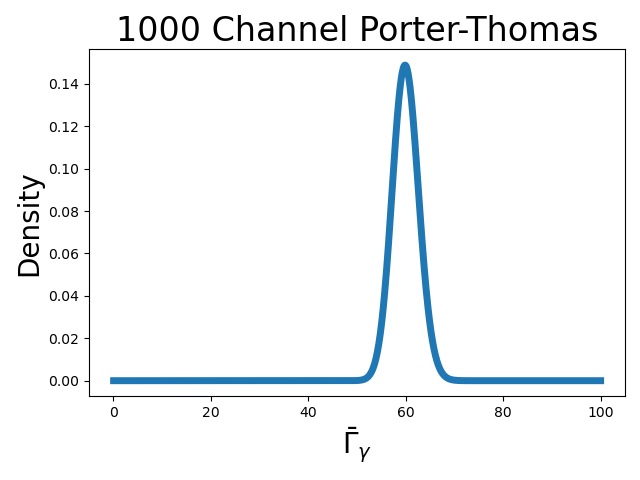

In [12]:
x = np.linspace(0.1,100,1000)
dof = 1000
avg = 60
from ATARI.syndat.sample_levels import wigner_PDF
figure()
# plot(x, wigner_PDF(x, 8), lw=5)
plot(x, sts.chi2.pdf(x, df=dof, loc=0, scale=avg/dof), lw=5)
ylabel("Density", fontsize=20)
# xlabel(r"$\frac{\Gamma_c}{\langle\Gamma_c\rangle}$", fontsize=20)
xlabel(r"$\bar{\Gamma}_{\gamma}$", fontsize=20)
title("1000 Channel Porter-Thomas", fontsize=24)
# title("Wigner Distribution", fontsize=24)
# xlabel("D", fontsize=20)
tight_layout()

True gamma width: 1, true average = 64.0
significance level: 0.005
Estimated DOF and Average: 4.449494496485504, 63.85954912363731
Statistical DOF: 0.9848379100286282
True gamma width: 10, true average = 64.0
significance level: 0.005
Estimated DOF and Average: 11.989887508353021, 66.68949945494646
Statistical DOF: 9.741895511733121
True gamma width: 50, true average = 64.0
significance level: 0.005
Estimated DOF and Average: 19.79687603558323, 66.32252786906092
Statistical DOF: 50.91571416600604
True gamma width: 100, true average = 64.0
significance level: 0.005
Estimated DOF and Average: 22.745519708562377, 66.48205073313758
Statistical DOF: 102.64827803185042
True gamma width: 1000, true average = 64.0
significance level: 0.005
Estimated DOF and Average: 23.3714831246616, 66.4014094061131
Statistical DOF: 966.0277659520696
True gamma width: 10000, true average = 64.0
significance level: 0.005
Estimated DOF and Average: 22.58767607836506, 66.223451044262
Statistical DOF: 1883.474420

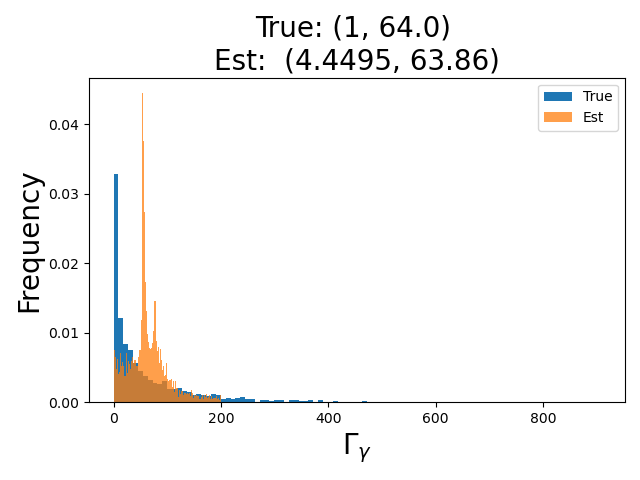

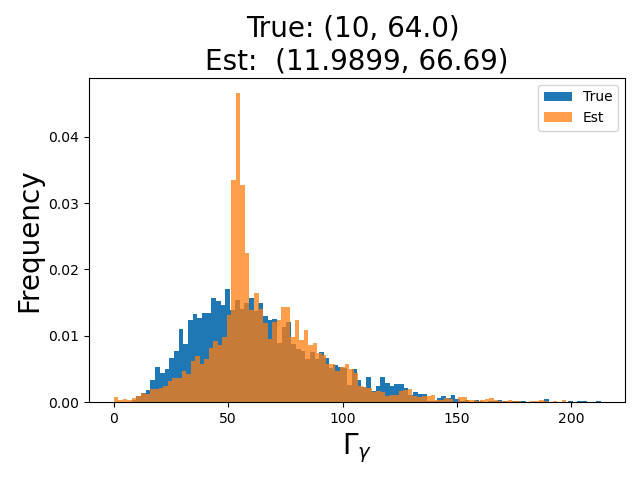

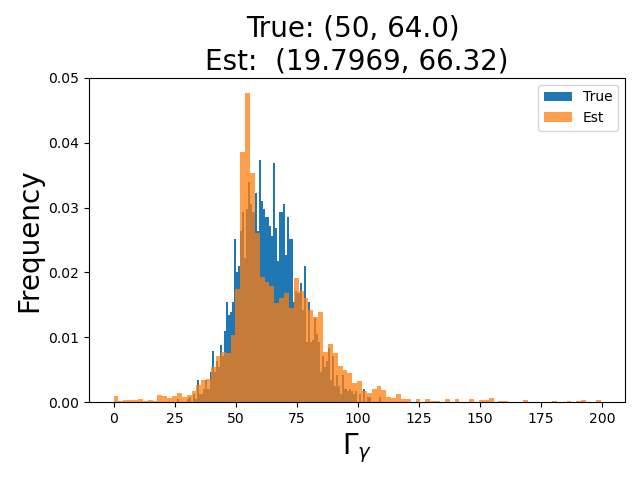

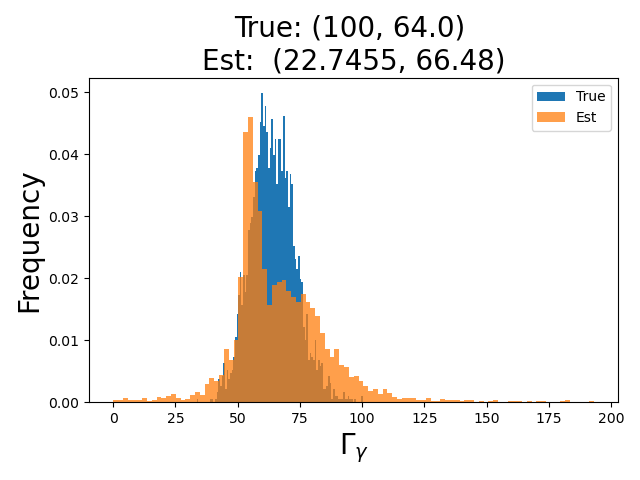

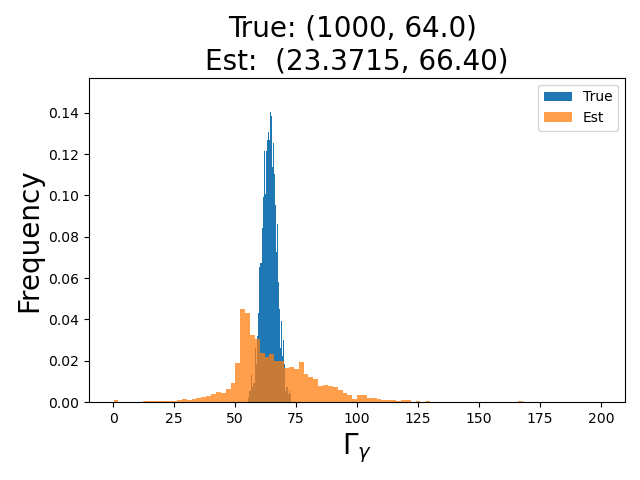

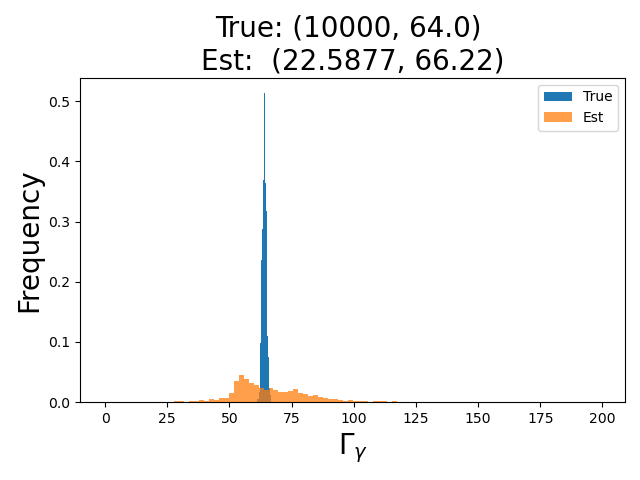

In [13]:
dof_estimates = []

for Gg_DOF_true in [1,10,50,100,1000,10000]:
        print(f"True gamma width: {Gg_DOF_true}, true average = 64.0")
        for Gg_avg in [60]: #[30, 60, 90]:
                for Gg_dof in [1000]:   #[10, 100, 1000, 10000]:
                        for sig in [0.005]:#[0.00001, 0.0001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25]:
                                print(f'significance level: {sig}')

                                target = np.array(Gg_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'])[np.array(Gg_dict[f'{Gg_DOF_true}_gaF{Gg_avg}_gdF{Gg_dof}_pv_{sig:0<10f}'])<200]
                                dof, loc, scale = sts.chi2.fit(target, floc=0)
                                dof_estimates.append(dof)
                                print(f"Estimated DOF and Average: {dof}, {scale*dof}")

                                bins = 100
                                figure()
                                out = hist(Gg_dict[f'{Gg_DOF_true}_true'], density=True, bins = bins, alpha=1, label="True")
                                out = hist(target, density=True, bins = bins, alpha=0.75, label="Est")
                                # xlim([0,150])
                                legend()
                                xlabel(r"$\Gamma_{\gamma}$", fontsize=20)
                                ylabel('Frequency', fontsize=20)
                                title(f"True: ({Gg_DOF_true}, 64.0) \nEst:  ({dof:<.4f}, {scale*dof:0.2f})" , fontsize=20)
                                tight_layout()
        
        dof, loc, scale = sts.chi2.fit(Gg_dict[f'{Gg_DOF_true}_true'], floc=0)
        # print(f"Statistical DOF and Average: {dof}, {scale*dof}")
        print(f"Statistical DOF: {dof}")



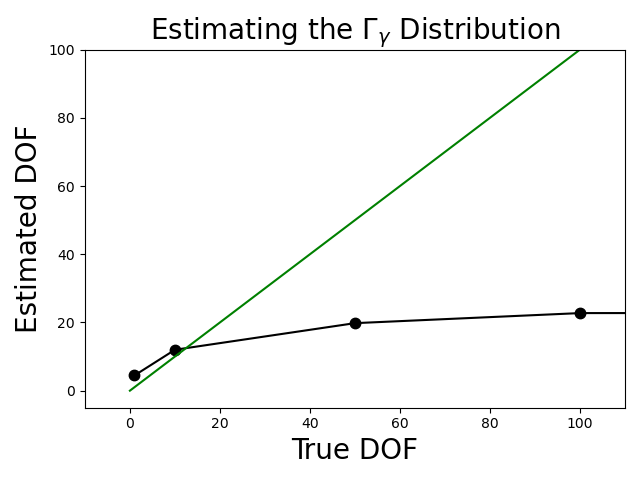

In [14]:
figure()
plot([1,10,50,100,1000,10000], dof_estimates, 'k.', ms=15, label="Estiamtes")
plot([1,10,50,100,1000,10000], dof_estimates, 'k', ms=15)
# plot(dof_estimates, [10,100,1000,10000], '.', ms=15)
plot( np.linspace(0,10000, 1000), np.linspace(0,10000, 1000) ,'g', label="1:1")
ylim([-5,100])
xlim([-10,110])
# xscale('log')
# yscale('log')
ylabel("Estimated DOF", fontsize=20)
xlabel("True DOF", fontsize=20)
title(r"Estimating the $\Gamma_{\gamma}$ Distribution", fontsize=20)
tight_layout()

### Test resonance sampling

In [15]:


Gg = []
Gn = []

for i in range(1000):
    resonance_ladder = Ta_pair.sample_resonance_ladder(exp.energy_domain, spin_groups, average_parameters)
    Gn.extend(list(resonance_ladder["Gn"].values))
    Gg.extend(list(resonance_ladder["Gg"].values))
    
Gt = np.array(Gg)+np.array(Gn)

In [16]:
dof, loc, scale = sts.chi2.fit(Gg, floc=0)  ## need to fit with different dof scales until loc is closest to 0

print(dof, scale*dof)

1005.6934233821858 63.95270848694001


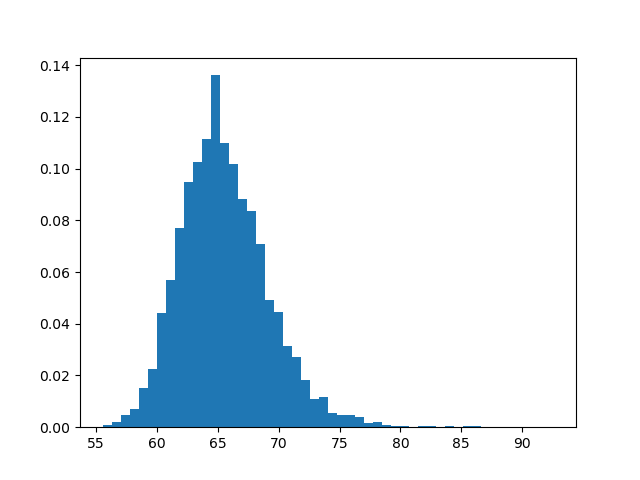

In [17]:
dof = 1000
mean = np.mean(Gg)

figure()
x = np.linspace(min(Gg), max(Gg), 1000)
# x = np.linspace(0, 1000, 1000)
bins = hist(Gt, bins=50, density=True)
# plot(x, sts.chi2.pdf(x, dof, scale=mean/dof))

In [18]:

res_par_avg = make_res_par_avg(D_avg = 8.79, 
                               Gn_avg= np.mean(penetration)*2*46.4, 
                               n_dof = 1, 
                               Gg_avg = 30, 
                               g_dof = 10, 
                               print = False)
res_par_avg

{'<D>': 8.79,
 '<Gn>': 1.617139017348665,
 'n_dof': 1,
 '<Gg>': 30,
 'g_dof': 10,
 'D01': 0.9943384234177864,
 'D99': 21.284662911191237,
 'Gn01': 0.000254032904177502,
 'Gn99': 10.729550169585444,
 'Gg01': 7.674636480561619,
 'Gg99': 69.62775347686306,
 'Gt01': 7.6748905134657965,
 'Gt99': 80.35730364644851}

In [19]:
gg = sample_RRR_widths(np.ones(1000), average_parameters['3.0']["<Gg>"], average_parameters['3.0']["g_dof"])
Gg = 2*gg

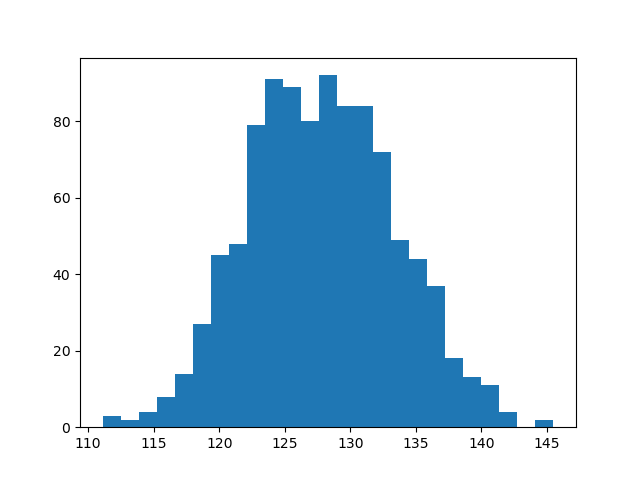

In [20]:
figure()
bins =hist(Gg, bins = 25)

#### If I sample on Gn, does the 2P(E) factor shake out?

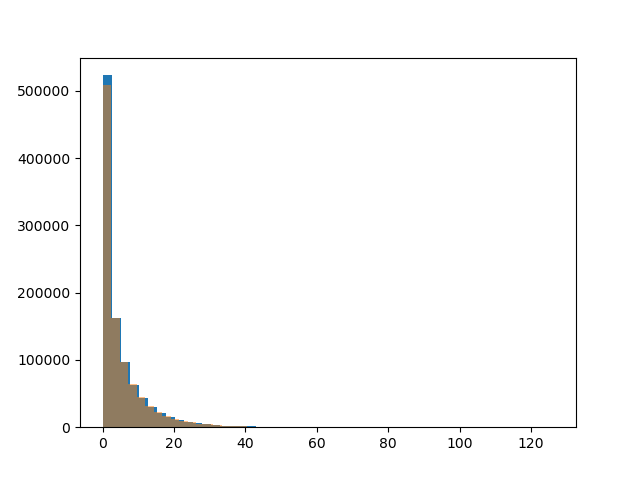

In [21]:
PE = 12

gn_avg = 5
gn = sample_RRR_widths(np.ones(1000000), gn_avg, 1)

Gn_avg = gn_avg*PE
Gn = sample_RRR_widths(np.ones(1000000), Gn_avg, 1)
figure()

bins = hist(gn, bins=50)
bins = hist(Gn/PE, bins=50, alpha=0.5)

In [22]:
# wig1 = syndat.sample_wigner_invCDF(10000)*3
# wig2 = syndat.sample_wigner_invCDF(10000)
# total = np.append(wig1,wig2)
# gb = endf_par.groupby('jspin')
# dfs_by_spin=[gb.get_group(x) for x in gb.groups]
# j3 = dfs_by_spin[0]
# j4 = dfs_by_spin[1]

# dE_j3 = np.diff(j3.E)
# dE_avg_j3 = endf_avg.dE[1]

# PT1 = syndat.sample_widths.sample_chisquare(10000,1)
# PT2 = syndat.sample_widths.sample_chisquare(10000,1)

# PT1 = PT1[PT1>0.2]
# PT2 = PT2[PT2<0.2]

# tot = np.append(PT1,PT2)

# figure()
# hist(PT1,bins=200,density=True)

# x = np.linspace(0,6,100)
# plot(x,syndat.sample_widths.chisquare_PDF(x, 1, 1))
# xlim([0,8])